In [2]:
# Importing dependencies
import pandas as pd
import os
import numpy as np
from datetime import datetime
from typing import List, Union, Iterator, Tuple
import plotly.express as px
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input, Activation, Flatten, Concatenate, Conv2D
from keras.models import Sequential
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import History, TensorBoard
from keras import Model
from keras.optimizers import Adam, RMSprop, Adagrad

## Reading data

In [3]:
data_path = '/Users/rahuln/PycharmProjects/PiCarNet/machine-learning-in-science-ii-2023'

In [4]:
def load_data(data_path: str) -> pd.DataFrame:
    """Loads data from csv file
    Params
    ------
    data_path: str
        Data path containing images and csv data
    Returns
    -------
    pd.DataFrame
        Loaded data as pandas dataframe
    """
    columns = ['image_id', 'angle', 'speed']
    data = pd.read_csv(os.path.join(data_path, 'training_norm.csv'), delimiter= ',', header=0, names = columns)

    return data

In [5]:
data = load_data(data_path)

In [6]:
data.head(5)

,image_id,angle,speed
0,1,0.4375,0.0
1,2,0.8125,1.0
2,3,0.4375,1.0
3,4,0.6250,1.0
4,5,0.5000,0.0


In [7]:
data['image_id'] = data.image_id.apply(lambda x: os.path.join(data_path, 'training_data/', str(x)) + '.png')

In [8]:
data.head()

,image_id,angle,speed
0,/Users/rahuln/PycharmProjects/PiCarNet/machine...,0.4375,0.0
1,/Users/rahuln/PycharmProjects/PiCarNet/machine...,0.8125,1.0
2,/Users/rahuln/PycharmProjects/PiCarNet/machine...,0.4375,1.0
3,/Users/rahuln/PycharmProjects/PiCarNet/machine...,0.6250,1.0
4,/Users/rahuln/PycharmProjects/PiCarNet/machine...,0.5000,0.0


## Data preprocessing

In [9]:
# train test split of dataset
def data_split(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Params
    ------
    data: pd.DataFrame
        Pandas dataframe containing all data.
    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        A tuple of train, test and val split
    """
    rnd = np.random.RandomState(seed=None)

    #train_data = data.sample(frac=0.7, random_state=rnd)
    #test_data = data.loc[~data.index.isin(train_data.index)]
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=rnd.seed(1234)) # split data with test size of 20%
    train_data, val_data = train_test_split(train_data, test_size=0.125, random_state=rnd.seed(1234)) # split data with overall test size of 10%

    return train_data, test_data, val_data

train_data, test_data, val_data = data_split(data)

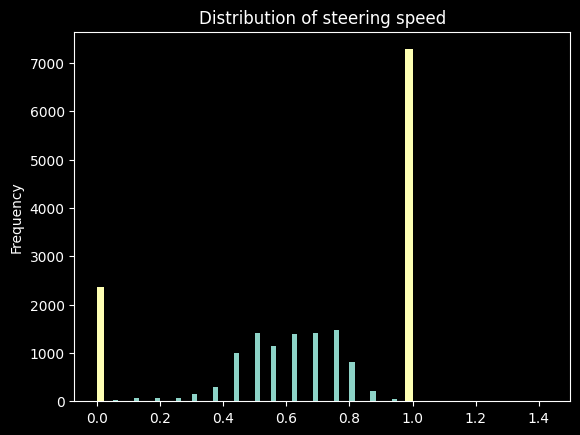

In [10]:
# plotting distribution of output labels
def visualize(data, attr):
    nBins = 60
    plt.hist(data.loc[:,attr], bins=nBins)
    plt.gca().set(title=f'Distribution of steering {attr}', ylabel='Frequency')

visualize(train_data, attr='angle')
visualize(train_data, attr='speed')

## Data pipeline

In [11]:
# Generate images on the fly while training model
def img_generator(train_data: pd.DataFrame, test_data: pd.DataFrame, val_data: pd.DataFrame, BATCH_SIZE: int) -> Tuple[Iterator, Iterator, Iterator]:
    """
    Params
    ------
    train_data: pd.DataFrame
        Pandas dataframe containing training data
    test_data: pd.DataFrame
        Pandas dataframe containing testing data
    val_data: pd.DataFrame
        Pandas dataframe containing validation data
    use_augmentation: bool
        If true use image augmentations

    Returns
    -------
    Tuple[Iterator, Iterator, Iterator]
        keras ImageDataGenerators used for training, testing and validating model.
    """

    train_generator = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.75, 1),
        shear_range=0.1,
        zoom_range=[0.75, 1],
        horizontal_flip=True,
        validation_split=0.2)

    val_generator = ImageDataGenerator(rescale=1.0 / 255)
    test_generator = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_generator.flow_from_dataframe(dataframe=train_data,
                                                          directory=None,
                                                          x_col='image_id',
                                                          y_col=['angle','speed'],
                                                          color_mode='rgb',
                                                          target_size=(224, 224),
                                                          class_mode='raw',
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True)

    test_generator = test_generator.flow_from_dataframe(dataframe=test_data,
                                                x_col='image_id',
                                                y_col=['angle', 'speed'],
                                                class_mode='raw',
                                                color_mode='rgb',
                                                target_size=(224, 224),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True)

    val_generator = val_generator.flow_from_dataframe(dataframe=val_data,
                                               x_col='image_id',
                                               y_col=['angle', 'speed'],
                                               class_mode='raw',
                                               color_mode='rgb',
                                               target_size=(224, 224),
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)



    return train_generator, test_generator, val_generator


In [27]:
# create base model using transfer learning
def create_baseline_model(input_shape, dropout_rate, optimizer) -> Sequential:
    """Creates a baseline model from MobileNetV2

    Params
    ------
    input_shape: input dimensions of image (224x224x3).
    dropout_rate: Applies Dropout to the input, to prevent over-fitting.
    optimizer: Optimization algorithm.

    Returns
    -------
    Sequential
        The keras model.
    """
    mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    mobilenet.trainable = False # Freeze the model

    # Rebuild top
    model = Sequential([
        mobilenet,
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(56, activation='softmax'),
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(dropout_rate),
        Flatten(),
        Dense(2, activation='linear')
    ])

    model.compile(loss=['mean_squared_error'], optimizer=optimizer, metrics=['mse', 'accuracy'])
    return model

# NOTE: we might need more complex model suggested by NVIDIA
# ref: https://towardsdatascience.com/teaching-cars-to-drive-using-deep-learning-steering-angle-prediction-5773154608f2

In [28]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3
input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

lr = 2e-3 # learning rate
decay = 0.01 # weight decay
dropout_rate = 0.1
optimizer = Adam(learning_rate=lr)  # optimizer

baseline_model = create_baseline_model(input_shape, dropout_rate, optimizer)

In [29]:
baseline_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 1280)       5120      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 1280)        0         
                                                                 
 dense_4 (Dense)             (None, 7, 7, 56)          71736     
                                                                 
 global_average_pooling2d_2   (None, 56)               0         
 (GlobalAveragePooling2D)                                        
                                                      

In [30]:
#training_ds, testing_ds, validation_ds = create_img_pipeline(train_ds, test_ds, val_ds)
train_generator, test_generator, val_generator = img_generator(train_data, test_data, val_data, BATCH_SIZE=64)

Found 9654 validated image filenames.
Found 2759 validated image filenames.
Found 1380 validated image filenames.


In [31]:
# defining callbacks
def get_callbacks(model: str) -> List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]:
    """Accepts the model name as a string and returns multiple keras callbacks

    Params
    ------
    model: str
        The name of model as a string

    Returns
    -------
    A list of multiple keras callbacks
    """
    logdir = (
        'logs/scalars/' + model + '_' + datetime.now().strftime('%Y%m%d-%H%M%S')
    ) # logging for each model
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

    early_stopping_callback = EarlyStopping(
        monitor='mse',
        min_delta=0.01,  # model should improve by at least 0.1%
        patience=10,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose=1,
        mode='min',
        restore_best_weights=True,  # restore the best model with the lowest validation error
    )

    model_checkpoint_callback = ModelCheckpoint(
        './data/models/' + model + '.h5',
        monitor='mse',
        verbose=0,
        save_best_only=True,  # save the best model
        mode='min',
        save_freq='epoch',  # save the model on disk at end of every epoch
    )
    return [model_checkpoint_callback, tensorboard_callback, early_stopping_callback]

In [32]:
tf.keras.backend.clear_session() # clear keras session

In [33]:
with tf.GradientTape() as tape:
    tape.reset() # This resets gradient tape

## Training model

In [34]:
callbacks = get_callbacks('baseline_model')
baseline_model.fit(train_generator,
               epochs=100,
                   validation_data=val_generator,
                   callbacks=callbacks,
                   workers=4,
                   verbose=1)

Epoch 1/100


2023-03-09 11:36:46.193951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


151/151 [==============================] - ETA: 0s - loss: 0.1038 - mse: 0.1038 - accuracy: 0.8825

2023-03-09 11:37:17.100858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


151/151 [==============================] - 36s 218ms/step - loss: 0.1038 - mse: 0.1038 - accuracy: 0.8825 - val_loss: 0.0868 - val_mse: 0.0868 - val_accuracy: 0.7536
Epoch 2/100
151/151 [==============================] - 33s 215ms/step - loss: 0.0267 - mse: 0.0267 - accuracy: 0.9535 - val_loss: 0.0682 - val_mse: 0.0682 - val_accuracy: 0.9000
Epoch 3/100
151/151 [==============================] - 33s 216ms/step - loss: 0.0238 - mse: 0.0238 - accuracy: 0.9565 - val_loss: 0.0393 - val_mse: 0.0393 - val_accuracy: 0.9739
Epoch 4/100
151/151 [==============================] - 35s 228ms/step - loss: 0.0216 - mse: 0.0216 - accuracy: 0.9626 - val_loss: 0.0252 - val_mse: 0.0252 - val_accuracy: 0.9652
Epoch 5/100
151/151 [==============================] - 34s 218ms/step - loss: 0.0198 - mse: 0.0198 - accuracy: 0.9640 - val_loss: 0.0148 - val_mse: 0.0148 - val_accuracy: 0.9703
Epoch 6/100
151/151 [==============================] - 33s 215ms/step - loss: 0.0189 - mse: 0.0189 - accuracy: 0.9682 - va

In [35]:
test_dir = os.path.join(data_path, 'test_data')

In [36]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    label_mode=None,
    color_mode='rgb',
    batch_size=64
)

Found 1020 files belonging to 1 classes.


In [37]:
pred = baseline_model.predict(test_ds)

2023-03-09 11:49:39.227414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 4s 152ms/step


In [40]:
pred_data = pd.DataFrame(data=pred, columns=['angle','speed'])

In [41]:
pred_data

,angle,speed
0,0.585358,0.794022
1,0.547771,0.826479
2,0.629216,0.710236
3,0.636752,0.724962
4,0.517572,0.772474
...,...,...
1015,-0.020049,1.043153
1016,0.307445,0.927990
1017,0.390521,0.886333
1018,0.615664,0.800519
